In [122]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load Data & Preprocessing

In [123]:
df = pd.read_csv('/content/AAPL_2006-01-01_to_2018-01-01.csv')

In [124]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB


In [126]:
# check missing values
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [127]:
# convert Date column type into date time
df['Date'] = pd.to_datetime(df['Date'])

In [128]:
# indexing and resampling data by day
df = df.set_index('Date')
df = df.resample('D').sum()
print(df.tail())
print(df.shape)

              Open    High     Low   Close    Volume
Date                                                
2017-12-25    0.00    0.00    0.00    0.00         0
2017-12-26  170.80  171.47  169.68  170.57  33185536
2017-12-27  170.10  170.78  169.71  170.60  21498213
2017-12-28  171.00  171.85  170.48  171.08  16480187
2017-12-29  170.52  170.59  169.22  169.23  25999922
(4379, 5)


In [129]:
# convert 0 value with nan
df = df.replace(0.0, np.nan)
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2017-12-25,NaN,NaN,NaN,NaN,NaN
2017-12-26,170.80,171.47,169.68,170.57,33185536.0
2017-12-27,170.10,170.78,169.71,170.60,21498213.0
2017-12-28,171.00,171.85,170.48,171.08,16480187.0
2017-12-29,170.52,170.59,169.22,169.23,25999922.0


In [130]:
# replace nan value by ffill method
df = df.fillna(method='ffill')
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2017-12-25,174.68,175.42,174.50,175.01,16349444.0
2017-12-26,170.80,171.47,169.68,170.57,33185536.0
2017-12-27,170.10,170.78,169.71,170.60,21498213.0
2017-12-28,171.00,171.85,170.48,171.08,16480187.0
2017-12-29,170.52,170.59,169.22,169.23,25999922.0


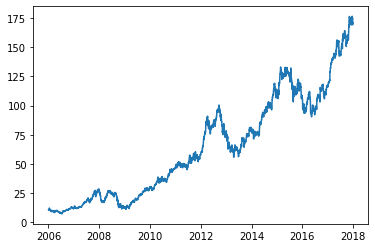

In [131]:
plt.plot(df['Close'])

In [132]:
values = df[['Open']].values.astype('float32')
values.shape

(4379, 1)

In [133]:
# scaling the data into range 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
values = scaler.fit_transform(values)

# Create & Train Model

In [134]:
# splitting data
train_size = int(len(values) * 0.7)
test_size = len(values) - train_size
train, test = values[:train_size, :], values[train_size:len(df), :]
print(train.shape, test.shape)

(3065, 1) (1314, 1)


In [135]:
# Create function for converting time series data into feature and label
def create_dataset(series, look_back):
  data_X = []
  data_y = []
  for i in range(len(series) - look_back):
    a = series[i:(i+look_back), 0]
    data_X.append(a)
    data_y.append(series[i+look_back, 0])
  return np.array(data_X), np.array(data_y)

In [136]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [137]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [138]:
#Create LSTM Architecture
model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(60, input_shape=(X_train.shape[1], X_train.shape[2])), # BISA PAKE >1 LAYER LSTM KALO NAMBAH PARAMETER return_secuences
      tf.keras.layers.Dense(40, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1),
])
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam',  metrics=["mae"])
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
3064/3064 - 6s - loss: 4.2476e-04 - mae: 0.0103
Epoch 2/10
3064/3064 - 4s - loss: 3.7745e-05 - mae: 0.0064
Epoch 3/10
3064/3064 - 4s - loss: 3.7567e-05 - mae: 0.0065
Epoch 4/10
3064/3064 - 4s - loss: 2.9255e-05 - mae: 0.0056
Epoch 5/10
3064/3064 - 4s - loss: 3.1181e-05 - mae: 0.0058
Epoch 6/10
3064/3064 - 4s - loss: 3.1553e-05 - mae: 0.0059
Epoch 7/10
3064/3064 - 4s - loss: 2.7597e-05 - mae: 0.0054
Epoch 8/10
3064/3064 - 4s - loss: 2.6006e-05 - mae: 0.0052
Epoch 9/10
3064/3064 - 4s - loss: 2.7436e-05 - mae: 0.0054
Epoch 10/10
3064/3064 - 4s - loss: 2.4212e-05 - mae: 0.0050


# Evaluate Model

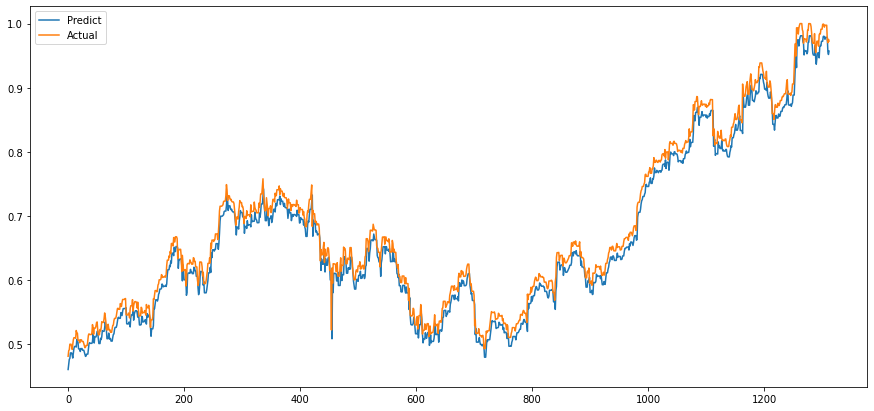

In [139]:
# Make a prediction with X_test and compare with actual value (y_test)
plt.figure(figsize=(15,7))
yhat = model.predict(X_test)
plt.plot(yhat, label='Predict')
plt.plot(y_test, label='Actual')
plt.legend()
plt.show()

In [140]:
# Inverse scaler
yhat_inverse = scaler.inverse_transform(yhat)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

#y_test = np.insert(y_test, 0, y_test[0])

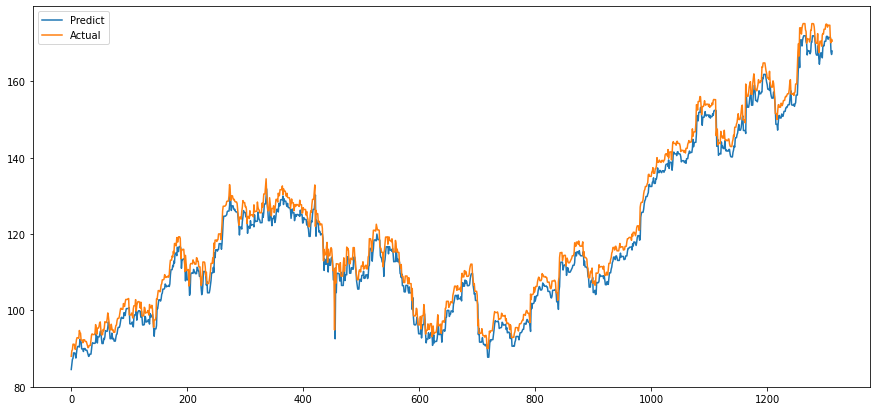

In [141]:
# plot inverted actual value (y_test) and predicted value(yhat_inverse)
plt.figure(figsize=(15,7))
plt.plot(yhat_inverse, label='Predict')
plt.plot(y_test, label='Actual')
plt.legend()
plt.show()

In [142]:
print('Mean Absolute Error:',mean_absolute_error(y_test, yhat_inverse))

Mean Absolute Error: 2.7470639
